In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
df = pd.read_excel('Fitness Club Data V4.xlsx')
df

,enrolldt,price,downpmt,monthdue,pmttype,use,age,gender,default
0,20190101,1830.2340,210.0000,6.0,CreditCard,1,0,0,0
1,20190101,1296.6660,1296.6660,6.0,Cash,0,0,0,0
2,20190101,930.4428,105.0000,5.0,Cash,0,0,0,0
3,20190102,798.3696,199.5924,9.0,DirectDebit,0,0,1,0
4,20190103,1206.2400,210.0000,9.0,Cheque,0,0,0,0
...,...,...,...,...,...,...,...,...,...
24838,20191206,0.0000,0.0000,4.0,CreditCard,1,99,0,0
24839,20191206,0.0000,0.0000,10.0,DirectDebit,0,99,0,0
24840,20191221,0.0000,0.0000,10.0,CreditCard,1,99,0,0
24841,20200306,0.0000,0.0000,0.0,Cheque,0,99,1,0


Data with price of 0, downpmt of 0, and age of 0,1,2,3,4,99 do not make much sense, so remove these records to make analysis.

In [ ]:
df1 = df[~df['age'].isin([0,1,2,3,4,99])].reset_index(drop=True)
df1 = df1[df1['price']!=0].reset_index(drop=True)
df1 = df1[df1['downpmt']!=0].reset_index(drop=True)
df1

,enrolldt,price,downpmt,monthdue,pmttype,use,age,gender,default
0,20210120,1111.2108,1111.2108,4.0,Cheque,1,9,0,0
1,20191221,1157.5200,147.0000,4.0,Cash,0,10,0,0
2,20200602,755.1600,84.0000,10.0,Cash,0,10,0,0
3,20201128,209.1600,209.1600,12.0,Cheque,0,10,1,0
4,20210129,1668.2400,840.0000,9.0,CreditCard,0,10,0,0
...,...,...,...,...,...,...,...,...,...
22668,20200824,859.3200,147.0000,7.0,DirectDebit,1,79,1,0
22669,20200827,650.1600,42.0000,7.0,DirectDebit,0,79,1,0
22670,20200903,1006.3200,84.0000,23.0,CreditCard,1,79,0,0
22671,20201009,547.3692,547.3692,34.0,Cheque,0,79,1,0


I split the enrolldt variable into year, month, and day to make analysis.

In [ ]:
df1['enrolldt'] = df1['enrolldt'].astype(str)

df1['year'] = df1['enrolldt'].str[:4]  # Extracting the first 4 characters
df1['month'] = df1['enrolldt'].str[4:6]  # Extracting the next 2 characters
df1['day'] = df1['enrolldt'].str[6:8]  # Extracting the last 2 characters

dff = df1.drop(columns=['enrolldt'])
dff

,price,downpmt,monthdue,pmttype,use,age,gender,default,year,month,day
0,1111.2108,1111.2108,4.0,Cheque,1,9,0,0,2021,01,20
1,1157.5200,147.0000,4.0,Cash,0,10,0,0,2019,12,21
2,755.1600,84.0000,10.0,Cash,0,10,0,0,2020,06,02
3,209.1600,209.1600,12.0,Cheque,0,10,1,0,2020,11,28
4,1668.2400,840.0000,9.0,CreditCard,0,10,0,0,2021,01,29
...,...,...,...,...,...,...,...,...,...,...,...
22668,859.3200,147.0000,7.0,DirectDebit,1,79,1,0,2020,08,24
22669,650.1600,42.0000,7.0,DirectDebit,0,79,1,0,2020,08,27
22670,1006.3200,84.0000,23.0,CreditCard,1,79,0,0,2020,09,03
22671,547.3692,547.3692,34.0,Cheque,0,79,1,0,2020,10,09


Now, let's build the ML model: __CatBoost Classifer model__.

1. __Why use classification model rather than regression model?__
   
   Because regression models predict continuous quantities, while classification models predict <u>discrete class labels</u>. So, classifcation model is preferred in this question since "default" (churn status) is a <u>binary variable</u> with values 0 (no churn) and 1 (churn).

2. __Why Catboost model?__
   
   The CatBoost model is a popular machine learning classifier recognized for <u>its high performance and efficiency</u>, especially in handling complex datasets. One of its standout features, compared to other models like XGBoost, is its ability to <u>directly process categorical variables</u> without extensive preprocessing. While models like XGBoost require all variables to be converted to numerical formats (e.g., converting values like “Direct Debit” into encoded numbers), CatBoost natively supports categorical data, making it both convenient and powerful for datasets with mixed variable types.

To assess our model's performance with the available data, we first split our dataset into training and testing sets. Since we don’t have an additional dataset for model evaluation, this split ensures we can train the model on one portion and validate its performance on the other. Here, we opted for an 80/20 split (randomly), where 80% of the data is used for training and 20% for testing.

In [ ]:
target = 'default'
X = dff.drop(columns=[target])  # Features
y = dff[target]                 # Target variable

categorical_features = ['pmttype', 'use', 'gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In training the model, we tune several key hyperparameters to optimize performance. The most fundamental of these are the *iteration* and *learning rate*.
- Iteration refers to the number of times the model updates its parameters to improve accuracy. Essentially, it represents the number of training cycles the model goes through.
- The learning rate, a crucial floating-point parameter, controls the model's pace of learning. A low learning rate may result in slow model convergence, whereas a high learning rate can lead to inaccurate learning. Standard learning rates are often set around 0.1 or 0.05 to balance speed and accuracy.
- These two hyperparameters play an essential role in model performance. Additional hyperparameters, such as depth (the complexity of the model) and verbose (logging level for insights during training), also contribute to fine-tuning. You can explore these further based on your interest.

With these key concepts in mind, model fitting (for CatBoost) is relatively straightforward and follows a process similar to that of training a regression model.

__Training the model:__

In [ ]:
model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, cat_features=categorical_features, verbose=100)

model.fit(X_train, y_train)

0:	learn: 0.5699633	total: 166ms	remaining: 1m 23s
100:	learn: 0.1638145	total: 5.33s	remaining: 21s
200:	learn: 0.1435898	total: 11.2s	remaining: 16.6s
300:	learn: 0.1285374	total: 17.3s	remaining: 11.5s
400:	learn: 0.1176770	total: 19.7s	remaining: 4.85s
499:	learn: 0.1083104	total: 21.8s	remaining: 0us


For testing the model, we use the testing dataset (20% part). Firstly, we use the trained model on the testing dataset, and then generate the report and calculated the accuracy by $\frac{\text{Number of Correct Predictions}}{\text{Number of All Predictions}}$. This model achieved __92.6% accuracy__.

__Testing the model:__

In [ ]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

np.sum(y_pred == y_test) / len(y_test)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3995
           1       0.72      0.63      0.67       540

    accuracy                           0.93      4535
   macro avg       0.83      0.80      0.81      4535
weighted avg       0.92      0.93      0.92      4535



0.9263506063947078

Finally, get the feature importance for the CatBoost model using this model's built-in feature_importance function.

In [ ]:
X.columns

Index(['price', 'downpmt', 'monthdue', 'pmttype', 'use', 'age', 'gender',
       'year', 'month', 'day'],
      dtype='object')

In [ ]:
x_labels = ['Membership Payment Price', 'Down Payment', 'Monthly Dues', 'Payment Types',
            'Facility Usage Frequency', 'Age', 'Gender', 'Year', 'Month', 'Day']

                    Feature  Importance
3             Payment Types   21.446372
1              Down Payment   16.727046
4  Facility Usage Frequency   13.633282
0  Membership Payment Price    9.951284
2              Monthly Dues    8.908235
8                     Month    8.332469
7                      Year    7.335032
5                       Age    6.241052
9                       Day    6.038337
6                    Gender    1.386891


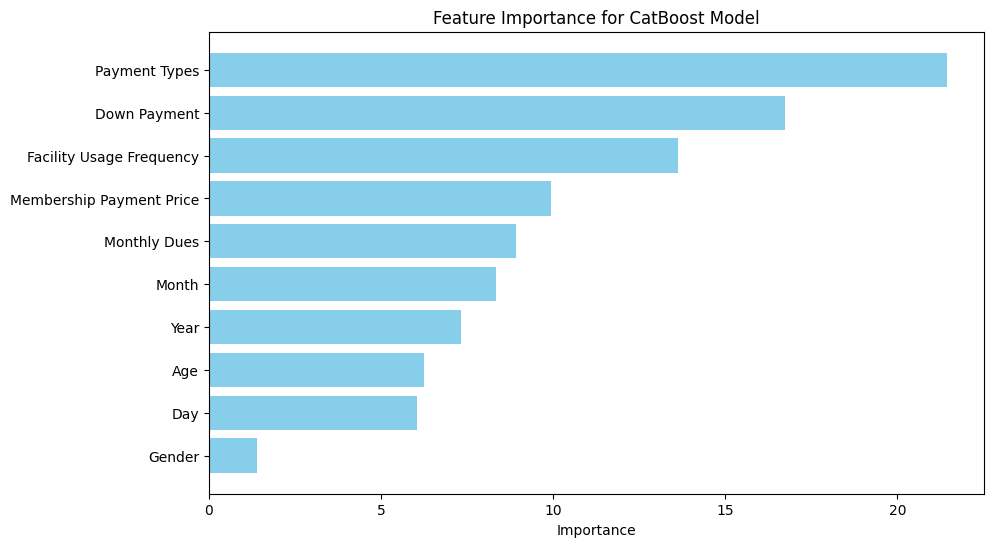

In [ ]:
feature_importances = model.get_feature_importance()

importance_df = pd.DataFrame({'Feature': x_labels, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance for CatBoost Model')
plt.gca().invert_yaxis()
plt.show()

The top three predictors impacting churn status were __Payment Types__, __Down Payment__, and __Facility Usage Frequency__. These results are logical and align with observed patterns:

- Customers using direct debit payments show a higher likelihood of retention.
- A higher down payment (above a thousand) correlates with increased retention.
- Frequent facility usage indicates a stronger customer commitment to the fitness center.